In [24]:
devtools::install_github("clairbarnes/rwwa")
library(rwwa)
library(MASS)
library(ciTools)

Skipping install of 'rwwa' from a github remote, the SHA1 (88fa2f80) has not changed since last install.
  Use `force = TRUE` to force installation



# Load covariates

In [4]:
gmst <- read.table("gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]
nao <- read.csv("NAO_series.csv", col.names = c("year", "era5", "nao"))[,c("year", "nao")]

df <- merge(merge(gmst, nao), read.csv("UKIre_SSI_precip.csv"))

cov_2023 <- df[df$year == 2023,c("gmst", "nao")]; rownames(cov_2023) <- "factual"
cov_cf <- rbind("hist" = data.frame(gmst = -1.2, nao = df$nao[df$year == 2023]),
                "neut" = data.frame(gmst = 0, nao = 0))

# SSI_mean

In [5]:
df$log_ssi <- log(df$SSI_mean)
df$cuberoot_ssi <- df$SSI_mean^{1/3}

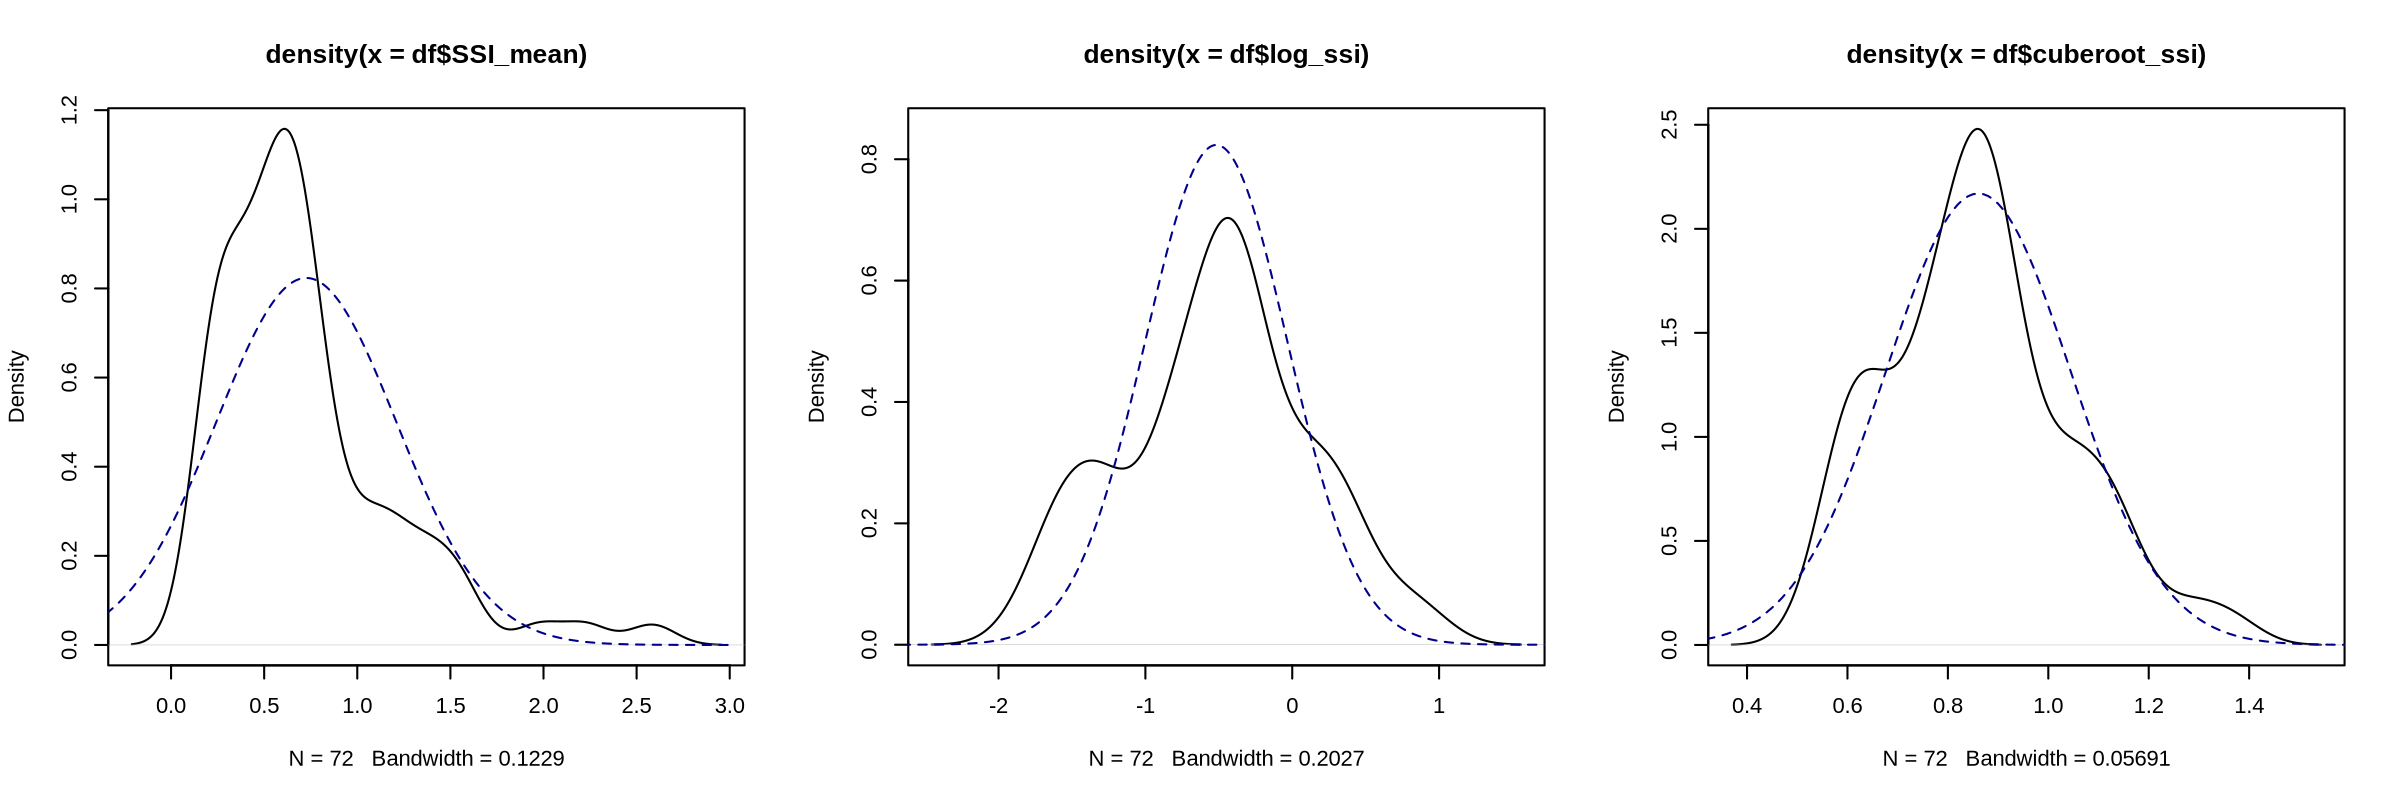

In [6]:
prep_window(c(1,3))
x <- seq(-3,3,0.01)
plot(density(df$SSI_mean)); lines(x, dnorm(x, mean(df$SSI_mean), sd(df$SSI_mean)), col = "darkblue", lty = 2)
plot(density(df$log_ssi), ylim = c(0,0.85)); lines(x, dnorm(x, mean(df$log_ssi), sd(df$SSI_mean)), col = "darkblue", lty = 2)
plot(density(df$cuberoot_ssi)); lines(x, dnorm(x, mean(df$cuberoot_ssi), sd(df$cuberoot_ssi)), col = "darkblue", lty = 2)

# Transformation is definitely required
# Data is more symmetrical after log transformation but tails are too heavy
# Cuberoot transformation seems to do better

In [7]:
mdl_logssi <- fit_ns("norm", "shift", df, "log_ssi", c("gmst", "nao"))
mdl_cuberootssi <- fit_ns("norm", "shift", df, "cuberoot_ssi", c("gmst", "nao"))

# residuals
res_logssi <- df$SSI_mean - exp(ns_pars(mdl_logssi)$loc)
res_cuberootssi <- df$SSI_mean - ns_pars(mdl_cuberootssi)$loc^3

In [8]:
# RMSE - slightly better fit from the cube root
sqrt(mean(res_logssi)^2)
sqrt(mean(res_cuberootssi)^2)

[1] 0.1184596

[1] 0.0815707

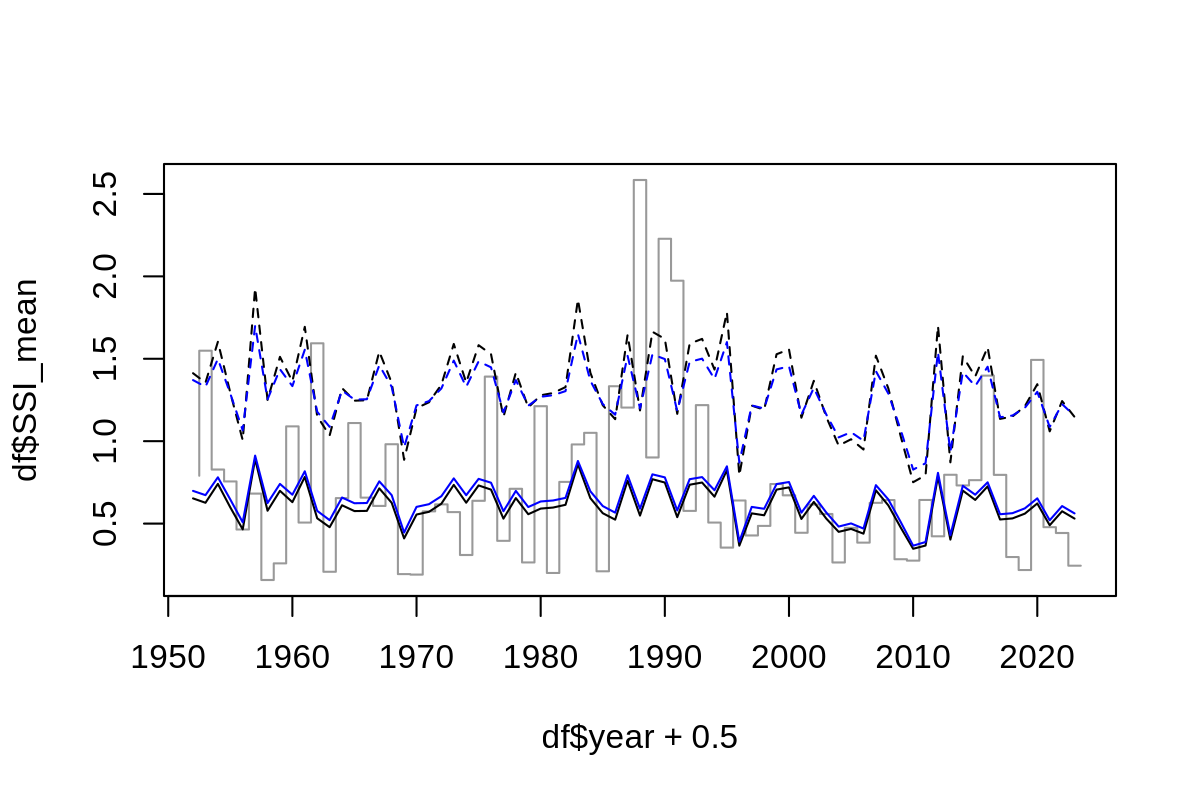

In [9]:
# fitted trend
prep_window(h = 4, w = 6)

plot(df$year+0.5, df$SSI_mean, type = "S", col = adjustcolor("black", 0.4))
lines(df$year, exp(ns_pars(mdl_logssi)$loc))
lines(df$year, exp(eff_return_level(mdl_logssi, 10)), lty = 2)

lines(df$year, ns_pars(mdl_cuberootssi)$loc^3, col = "blue")
lines(df$year, eff_return_level(mdl_cuberootssi, 10)^3, lty = 2, col = "blue")

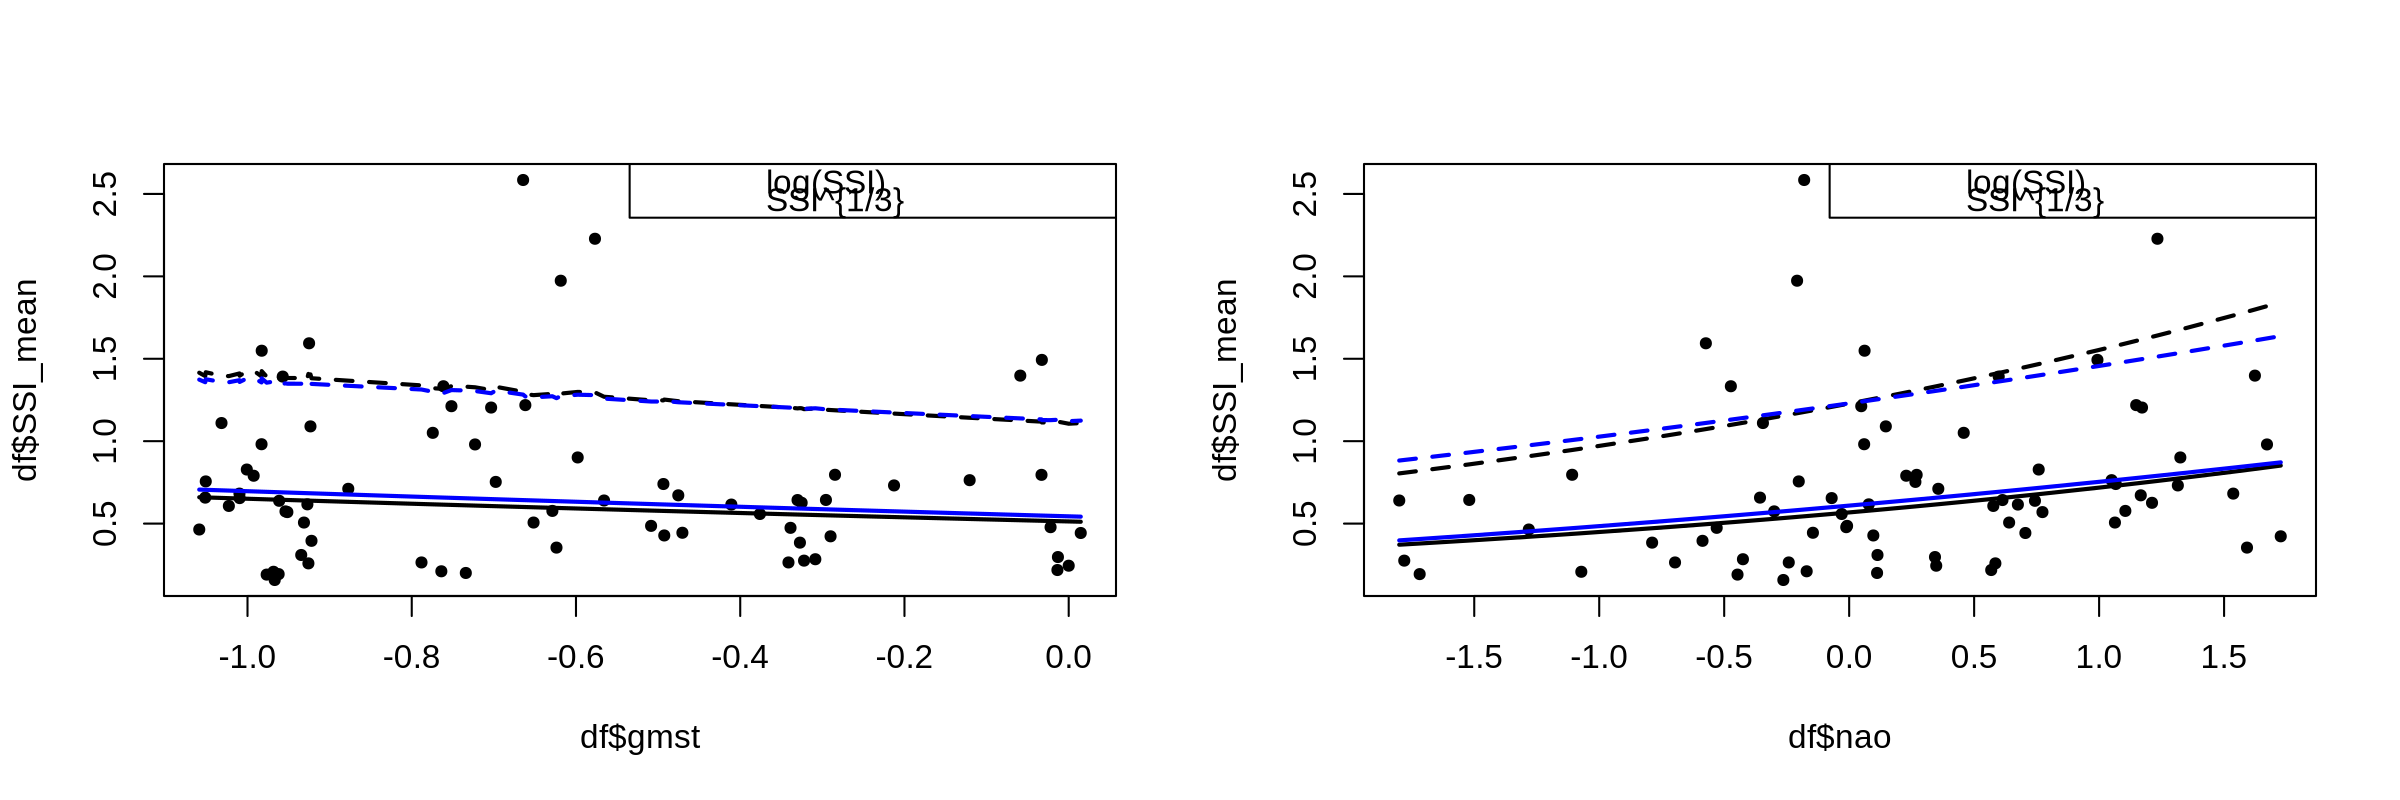

In [10]:
prep_window(c(1,2), h = 4, w = 6)

plot(df$gmst, df$SSI_mean)
covdf <- data.frame(gmst = df$gmst, nao = mean(df$nao))[order(df$gmst),]
lines(covdf$gmst, exp(ns_pars(mdl_logssi, fixed_cov = covdf)$loc), lwd = 2)
lines(covdf$gmst, exp(eff_return_level(mdl_logssi, 10, fixed_cov = covdf))[order(df$gmst)], lwd = 2, lty = 2)
lines(covdf$gmst, (ns_pars(mdl_cuberootssi, fixed_cov = covdf)$loc)^3, lwd = 2, col = "blue")
lines(covdf$gmst, (eff_return_level(mdl_cuberootssi, 10, fixed_cov = covdf)^3)[order(df$gmst)], lwd = 2, col = "blue", lty = 2)
legend("topright", c("log(SSI)", "SSI^{1/3}"), col = c("black", "blue"))


plot(df$nao, df$SSI_mean)
covdf <- data.frame(gmst = mean(df$gmst), nao = df$nao)[order(df$nao),]
lines(covdf$nao, exp(ns_pars(mdl_logssi, fixed_cov = covdf)$loc), lwd = 2)
lines(covdf$nao, exp(eff_return_level(mdl_logssi, 10, fixed_cov = covdf)), lwd = 2, lty = 2)
lines(covdf$nao, (ns_pars(mdl_cuberootssi, fixed_cov = covdf)$loc)^3, lwd = 2, col = "blue")
lines(covdf$nao, (eff_return_level(mdl_cuberootssi, 10, fixed_cov = covdf)^3), lwd = 2, col = "blue", lty = 2)
legend("topright", c("log(SSI)", "SSI^{1/3}"), col = c("black", "blue"))


# precip_mean

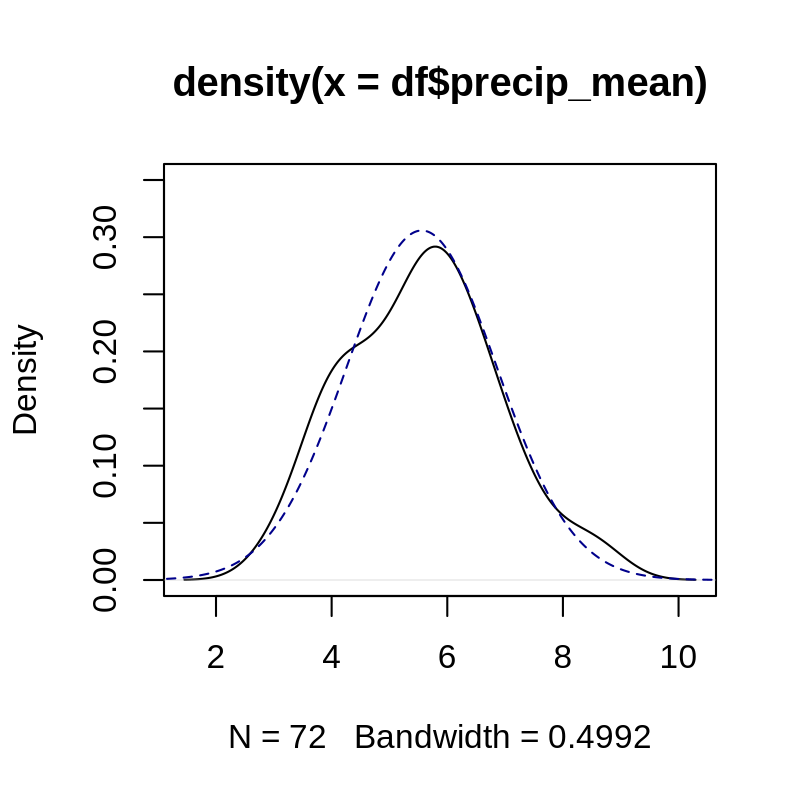

In [11]:
prep_window(c(1,1))
x <- seq(0,12,0.01)
plot(density(df$precip_mean), ylim = c(0,0.35)); lines(x, dnorm(x, mean(df$precip_mean), sd(df$precip_mean)), col = "darkblue", lty = 2)

# already pretty Gaussian, no transformation needed

In [12]:
mdl_meanpr <- fit_ns("norm", "fixeddisp", df, "precip_mean", c("gmst", "nao"))

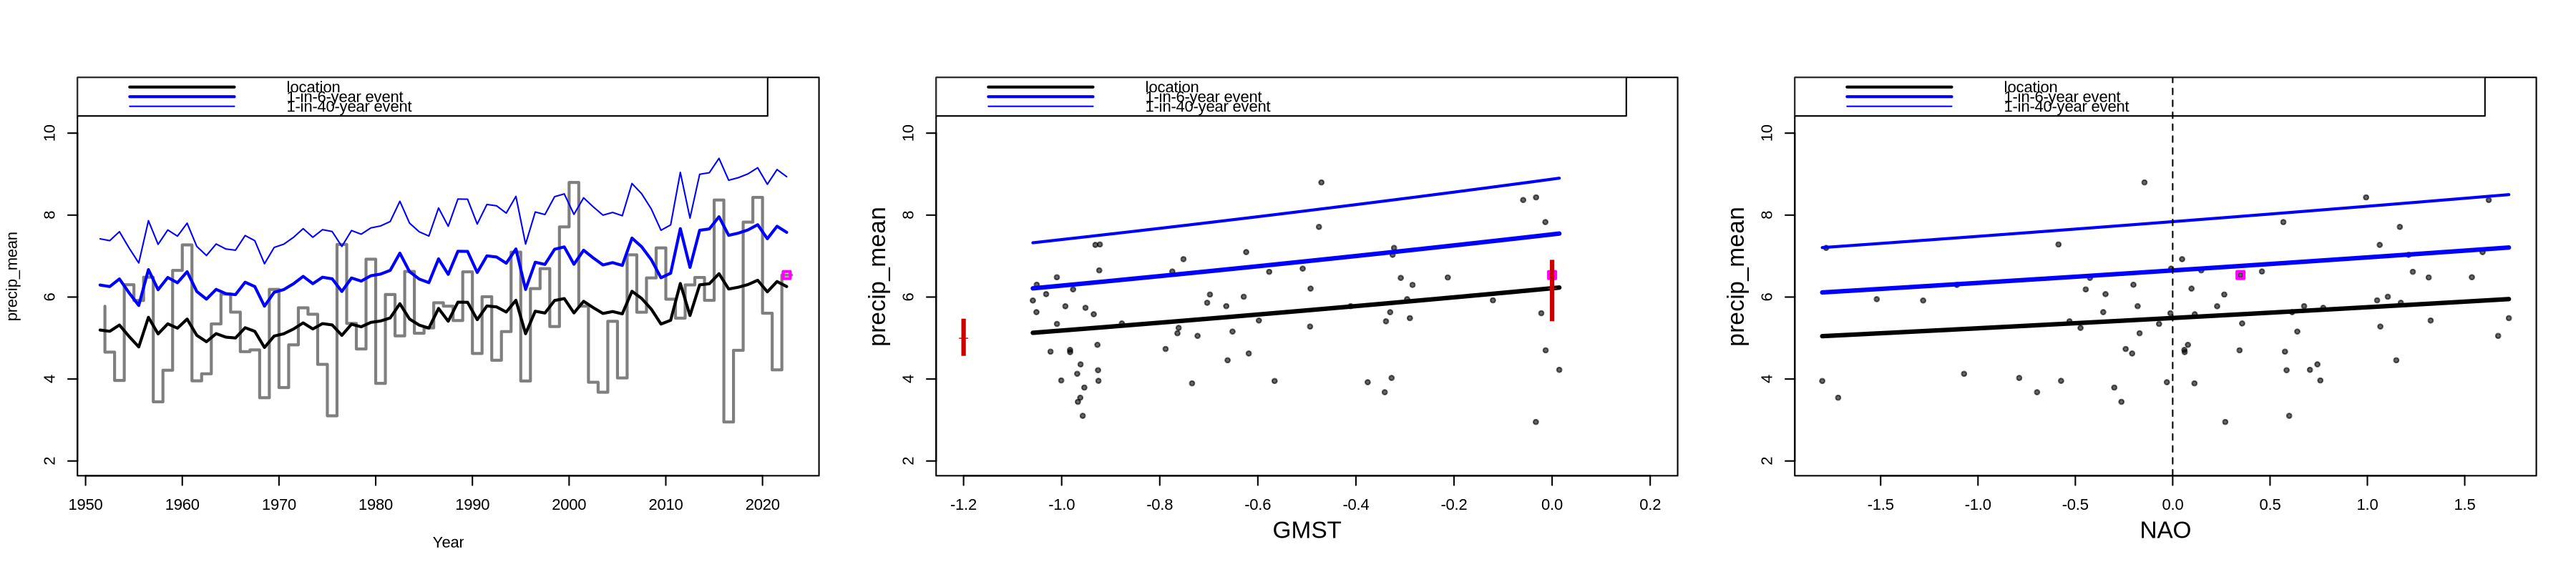

In [13]:
prep_window(c(1,3), h = 4, w = 6)

plot_trend(mdl_meanpr, ylim = c(2,11))
plot_covtrend(mdl_meanpr, xcov = "gmst", ylim = c(2,11), ci_cov = data.frame(gmst = c(0,-1.2), nao = mean(df$nao)))
plot_covtrend(mdl_meanpr, xcov = "nao", ylim = c(2,11))
abline(v = 0, lty = 2)

# precip_max

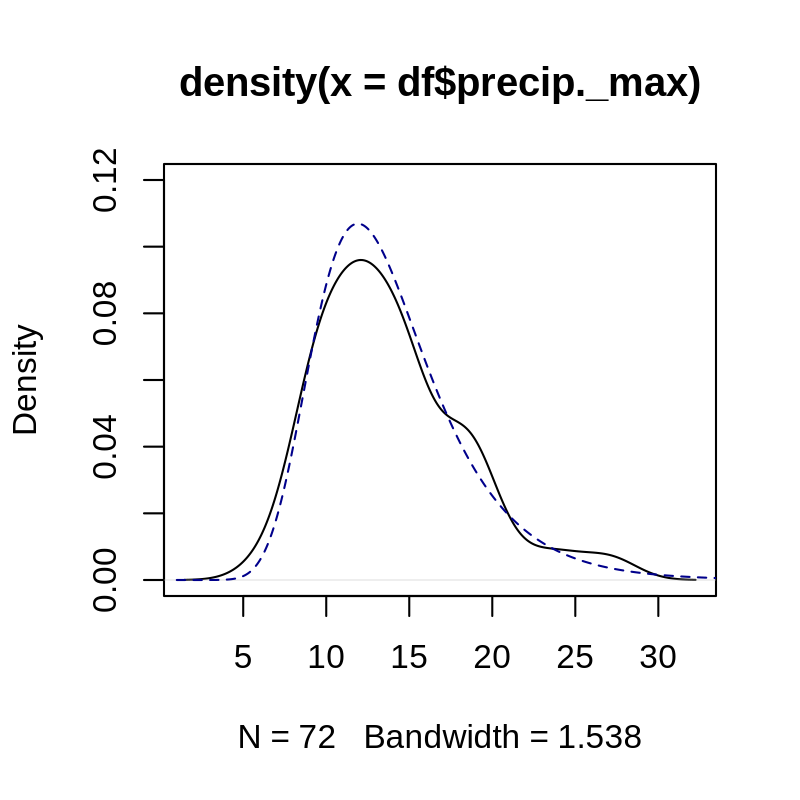

In [14]:
prep_window(c(1,1))
x <- seq(1,40,0.01)
plot(density(df$precip._max), ylim = c(0,0.12))
pars <- strip(fevd(df$precip._max))
lines(x, devd(x, loc = pars["location"], scale = pars["scale"], shape = pars["shape"], type = "GEV"), col = "darkblue", lty = 2)

# SSI_count

In [15]:
m = mean(df$SSI_count); v = var(df$SSI_count); d = v/m
d
# very much not dispersion = 1

[1] 1.762801

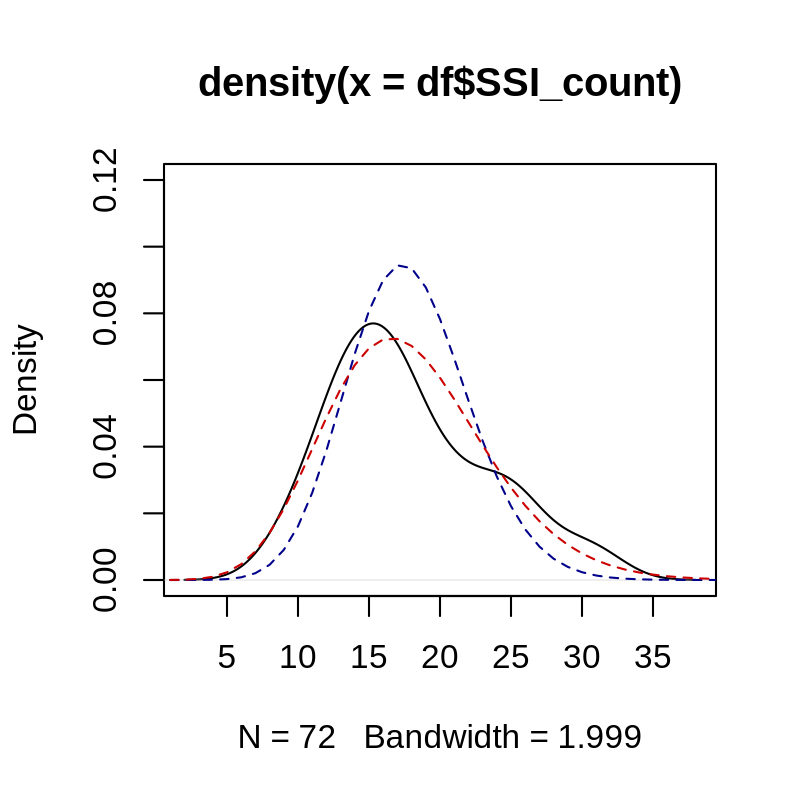

In [16]:
prep_window(c(1,1))
x <- seq(1,40)
plot(density(df$SSI_count), ylim = c(0,0.12))
lines(x, dpois(x, lambda = mean(df$SSI_count)), col = "darkblue", lty = 2) # Poisson is not a good fit...
lines(x, dnbinom(x, size = (m/(d-1)), mu = m), col = "red3", lty = 2) # negative binomial isn't bad though

In [17]:
mdl_nb <- glm.nb(SSI_count ~ gmst + nao, df)

In [26]:
# expected change in number of storms per season
E_storms <- predict(mdl_nb, newdata = rbind(cov_2023, cov_cf), type = "response")

E_storms["factual"] - E_storms["hist"]
E_storms["factual"] - E_storms["neut"]

factual 
-3.02795

factual 
0.8952698

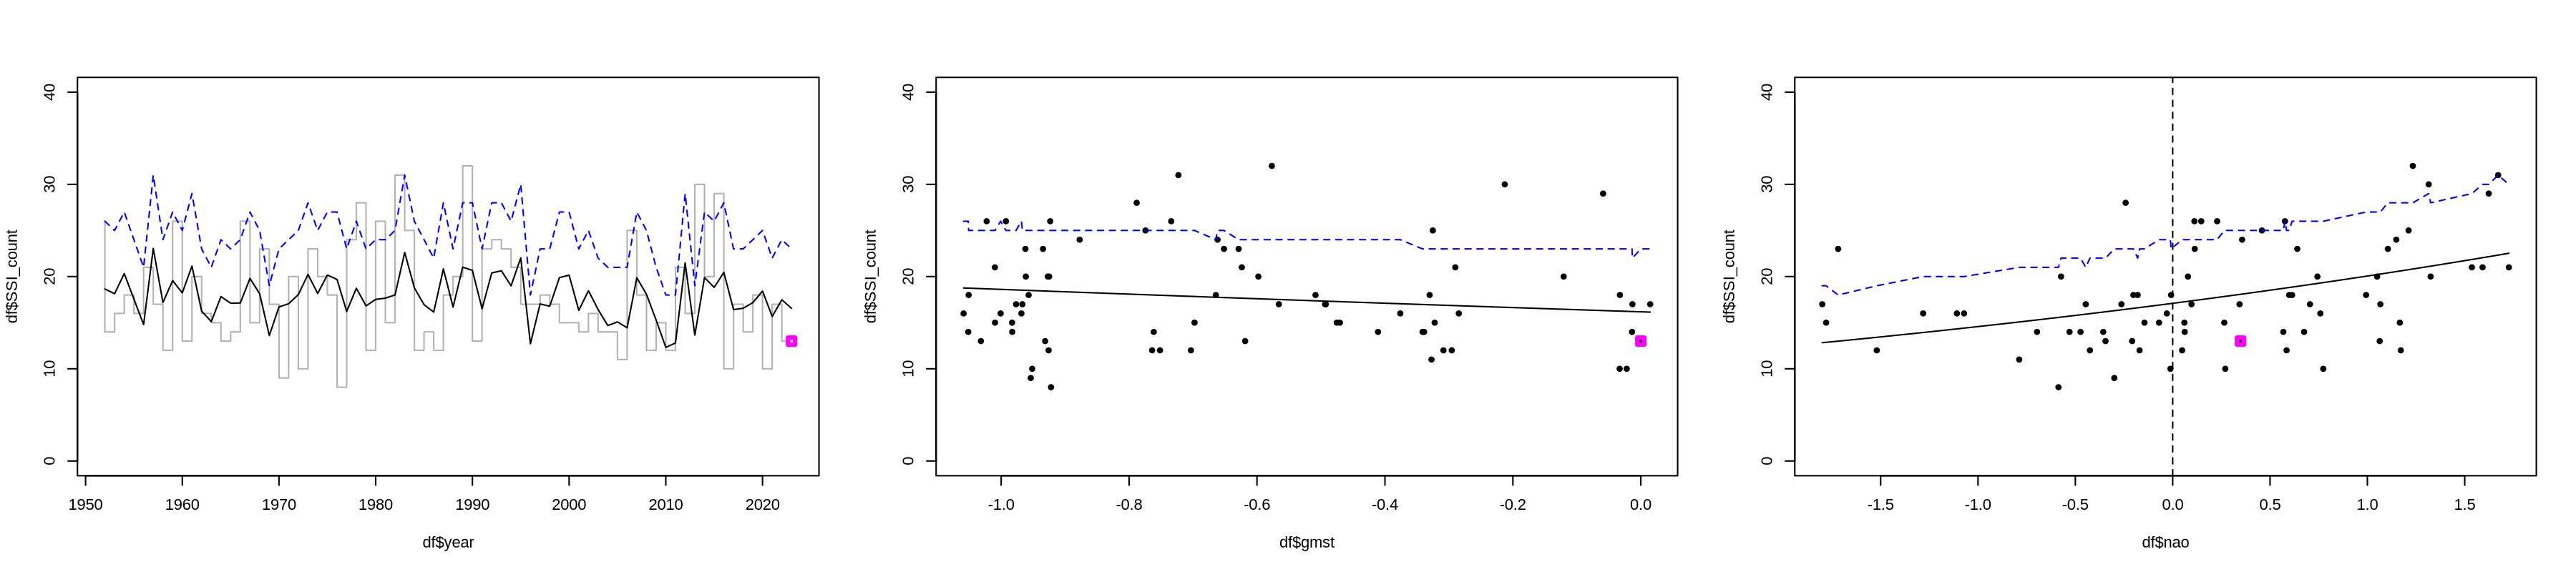

In [40]:
prep_window(c(1,3), w = 6)
ylim <- c(0,40)

plot(df$year, df$SSI_count, type = "S", col = adjustcolor("black", 0.3), ylim = ylim)
lines(df$year, fitted(mdl_nb))
points(df[df$year == 2023,c("year", "SSI_count")], col = "magenta", pch = 0, lwd = 3)
lines(df$year, add_quantile(df, mdl_nb, p = c(0.9))[,"quantile0.9"], lty = 2, col = "blue")


xcov <- df$gmst[order(df$gmst)]
cov_df <- data.frame(SSI_count = df$SSI_count, gmst = xcov, nao = mean(df$nao))
plot(df$gmst, df$SSI_count, ylim = ylim)
lines(xcov, predict(mdl_nb, newdata = cov_df, type = "response"))
points(df[df$year == 2023,c("gmst", "SSI_count")], col = "magenta", pch = 0, lwd = 3)
lines(xcov, add_quantile(cov_df, mdl_nb, p = c(0.9))[,"quantile0.9"], lty = 2, col = "blue")

xcov <- df$nao[order(df$nao)]
cov_df <- data.frame(SSI_count = df$SSI_count, gmst = mean(df$gmst), nao = xcov)
plot(df$nao, df$SSI_count, ylim = ylim)
lines(xcov, predict(mdl_nb, newdata = cov_df, type = "response"))
abline(v = 0, lty = 2)
points(df[df$year == 2023,c("nao", "SSI_count")], col = "magenta", pch = 0, lwd = 3)
lines(xcov, add_quantile(cov_df, mdl_nb, p = c(0.9))[,"quantile0.9"], lty = 2, col = "blue")

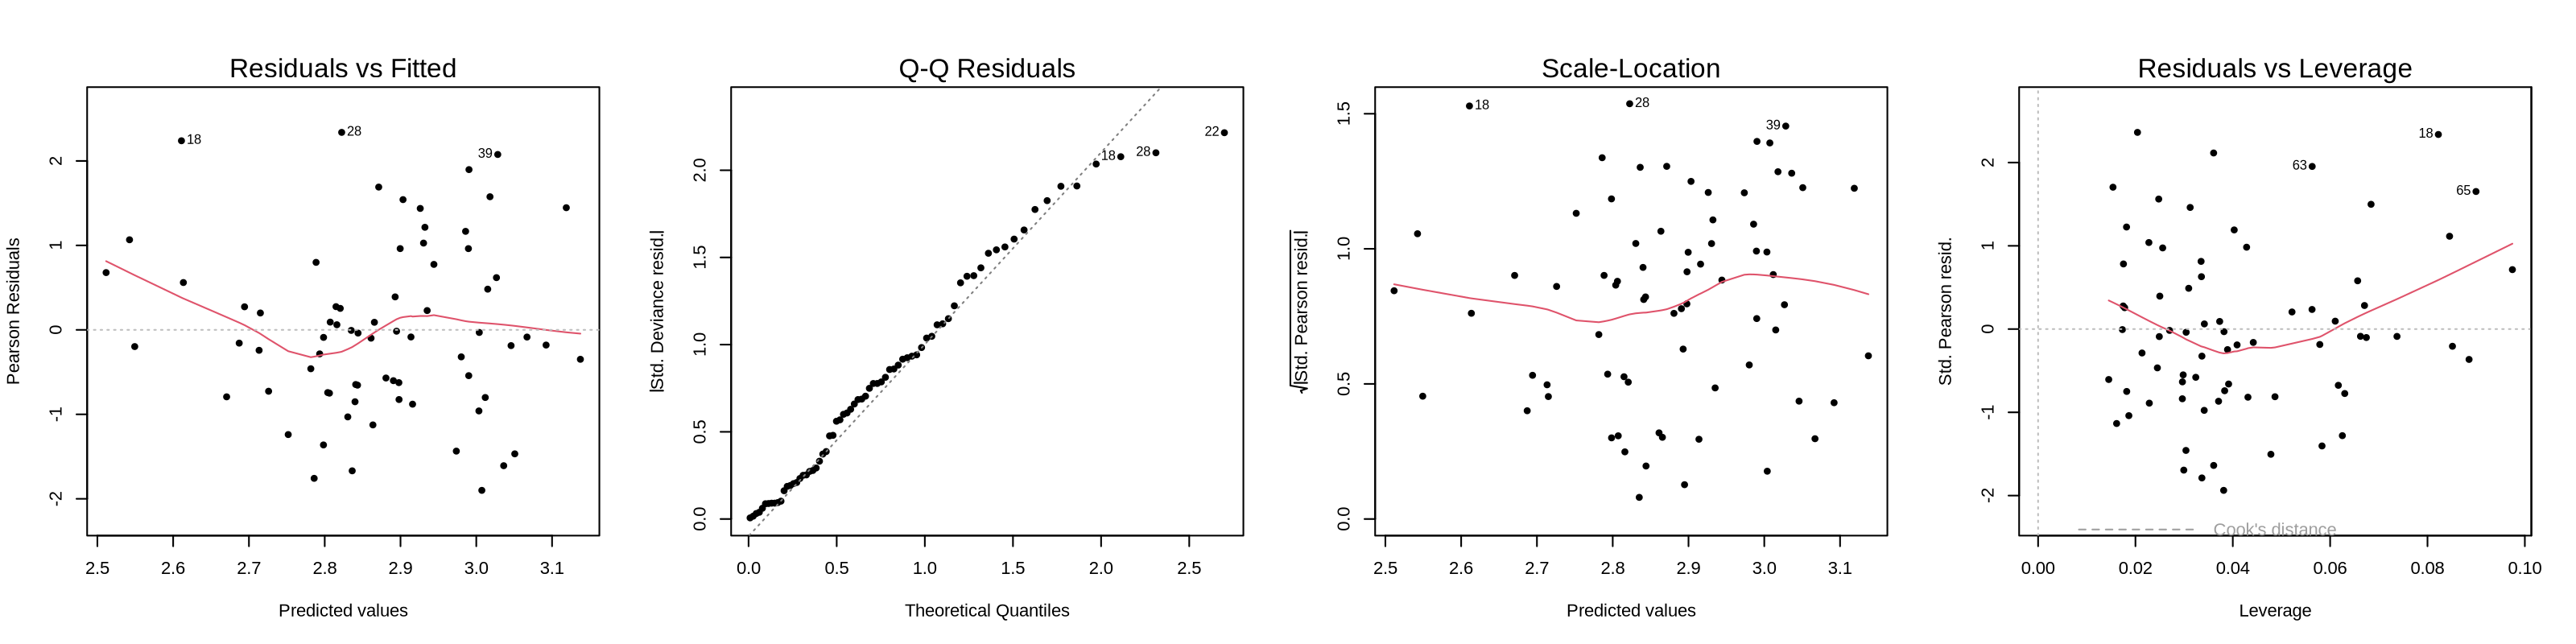

In [21]:
prep_window(c(1,4))
plot(mdl_nb)